# **Measuring how Frozen the Labor Market is** 
## (01-01-2001 to 04-01-2025)



---

### 📊 **Derived Features Table**

| **Feature Name**                   | **Equation**                                              | **Interpretation**                                   | **Why It Matters**                                                                 | **Supply or Demand** |
| ---------------------------------- | --------------------------------------------------------- | ---------------------------------------------------- | ---------------------------------------------------------------------------------- | -------------------- |
| **OpeningsPerUnemployed**          | `Job_Openings_Rate / Unemployment_Level`                  | Openings per unemployed person                       | Signals labor tightness or slack                                                   | Demand               |
| **HiresPerUnemployed**             | `Hires_Rate / Unemployment_Level`                         | Hires per unemployed person                          | Indicates efficiency of unemployed absorption                                      | Demand               |
| **Inverse\_HiresPerUnemployed**    | `1 / HiresPerUnemployed`                                  | Low hire rate relative to unemployed                 | Highlights matching inefficiency                                                   | Supply (friction)    |
| **QuitsPerLayoffs**                | `Quits_Rate / Layoffs_and_Discharges`                     | Voluntary vs involuntary separations                 | Indicates worker confidence vs. forced exits                                       | Supply               |
| **LayoffsPerOpening**              | `Layoffs_and_Discharges / Job_Openings_Rate`              | Layoffs per job opening                              | Contradictory signal; layoffs despite openings = instability                       | Supply               |
| **NILFWJNPerPop**                  | `Not_in_Labor_Force_WantAJobNow / Total_Population`       | Hidden slack (not in labor force but want work)      | Captures discouraged potential workers missed in unemployment rate                 | Supply               |
| **U6\_U3\_Spread**                 | `U6_Unemployment_Rate - U3_Unemployment_Rate`             | Underemployment spread                               | Measures slack beyond headline unemployment                                        | Supply               |
| **RealAvgWeeklyEarningsYoY**       | `Avg_Weekly_Earnings.pct_change(12) - CPI.pct_change(12)` | Real wage growth (inflation-adjusted)                | Indicates worker purchasing power; low growth may signal distress                  | Supply               |
| **TempHelpEmploymentYoY**          | `Temp_Help_Services.pct_change(12)`                       | YoY growth in temp employment                        | Fast-moving labor demand signal; early sign of employer urgency/confidence         | Demand               |
| **PrimeLFPR** *(New)*              | `LFPR_25_54`                                              | Participation rate among prime-age workers           | Core supply-side strength; declining rates may signal structural disengagement     | Supply               |
| **PartTimePerLaborForce** *(New)* | `PartTime_Econ / Labor_Force`                             | Share of labor force in involuntary part-time        | Indicates underemployment or weak job quality even among the employed              | Supply               |
| **U4\_Rate** *(New)*               | `LNS13327707`                                             | Unemployed + discouraged workers as % of labor force | Captures hidden slack not visible in headline stats                                | Supply               |
| **ReentrantsPerLaborForce** *(New)*          | `LNS13023558`                                | Former workers re-entering the labor force           | Tracks return of latent labor supply; higher rates signal renewed labor confidence | Supply               |
| **LongTermUnempRate** *(New)*       | `Unemployed_27wks+ / Total_Unemployed`                    | Share of unemployment that is long-term              | High levels reflect structural weakness or scarring from economic shocks           | Supply               |
| **InsuredUnemploymentRate** *(New)*         | `UI_Claims / Total_Unemployed`                            | % of unemployed receiving unemployment insurance     | Reflects both policy coverage and economic strain among jobless workers            | Supply               |


---

In [25]:
import pandas as pd
import sqlite3

# === Load CSV files ===

# JOLTS series
Layoffs_df = pd.read_csv('JOLTS/JTSLDL.csv')  # Layoffs
Quits_df = pd.read_csv('JOLTS/JTSQUL.csv')  # Quits

Hires_df = pd.read_csv('JOLTS/JTSHIL.csv')    # Hires
Job_Openings_df = pd.read_csv('JOLTS/JTSJOR.csv')  # Job Openings

# Demand_vs_Supply series
Temp_Help_df = pd.read_csv('Demand_vs_Supply/TEMPHELPS.csv')
Avg_Weekly_Earnings_df = pd.read_csv('Demand_vs_Supply/CES0500000011.csv')  # Assume this is weekly earnings
CPI_df = pd.read_csv('Demand_vs_Supply/CPIAUCSL.csv')
Population_df = pd.read_csv('Demand_vs_Supply/POPTHM.csv')  # Optional

U3_df = pd.read_csv('Demand_vs_Supply/UNRATE.csv')     # U-3
U4_df = pd.read_csv('Demand_vs_Supply/U4RATE.csv')     # U-4
U6_df = pd.read_csv('Demand_vs_Supply/U6RATE.csv')     # U-6
Unemployment_Level_df = pd.read_csv('Demand_vs_Supply/UNEMPLOY.csv')

NILFWJN_df = pd.read_csv('JOLTS/NILFWJN.csv')
Median_Weeks_Unemployed_df = pd.read_csv('Demand_vs_Supply/UEMPMED.csv')
PartTime_df = pd.read_csv('Demand_vs_Supply/LNS12032194.csv')
Prime_LFPR_df = pd.read_csv('Demand_vs_Supply/LNS11300060.csv')
Reentrants_df = pd.read_csv('Demand_vs_Supply/LNS13023569.csv')  # Count of reentrants
LongTermUnemp_df = pd.read_csv('Demand_vs_Supply/UEMP27OV.csv')
CLF_df = pd.read_csv('Demand_vs_Supply/CLF16OV.csv')
UI_Rate_df = pd.read_csv('Demand_vs_Supply/IURSA.csv')  # You may need to adjust if this isn't UI Rate

# New: Wage Cost Indices
ECI_df = pd.read_csv('Demand_vs_Supply/ECIALLCIV.csv')     # Employment Cost Index
ULC_df = pd.read_csv('Demand_vs_Supply/ULCNFB.csv')        # Unit Labor Costs
Labor_Share_df = pd.read_csv('Demand_vs_Supply/PRS85006173.csv')  # Labor Share of Income

# === SQLite in-memory setup ===
conn = sqlite3.connect(':memory:')

# === Load tables ===
dataframes = {
    'Layoffs': Layoffs_df,
    'Temp_Help': Temp_Help_df,
    'Weekly_Earnings': Avg_Weekly_Earnings_df,
    'CPI': CPI_df,
    'Population': Population_df,
    'U3': U3_df,
    'U4': U4_df,
    'U6': U6_df,
    'Unemployment_Level': Unemployment_Level_df,
    'Job_Openings': Job_Openings_df,
    'Quits': Quits_df,
    'Hires': Hires_df,
    'NILFWJN': NILFWJN_df,
    'Median_Weeks_Unemployed': Median_Weeks_Unemployed_df,
    'Involuntary_Part_Time': PartTime_df,
    'Prime_LFPR': Prime_LFPR_df,
    'Reentrants': Reentrants_df,
    'Long_Term_Unemployed': LongTermUnemp_df,
    'CLF': CLF_df,
    'UI_Rate': UI_Rate_df,
    'ECI': ECI_df,
    'ULC': ULC_df,
    'Labor_Share': Labor_Share_df,
}

for name, df in dataframes.items():
    df.to_sql(name, conn, index=False, if_exists='replace')

# === SQL Query to Merge on observation_date ===
sql_query = """
SELECT *
FROM Hires
JOIN Layoffs ON Hires.observation_date = Layoffs.observation_date
JOIN Job_Openings ON Hires.observation_date = Job_Openings.observation_date
JOIN Quits ON Hires.observation_date = Quits.observation_date
JOIN Unemployment_Level ON Hires.observation_date = Unemployment_Level.observation_date
JOIN Temp_Help ON Hires.observation_date = Temp_Help.observation_date
JOIN Weekly_Earnings ON Hires.observation_date = Weekly_Earnings.observation_date
JOIN Population ON Hires.observation_date = Population.observation_date
JOIN U6 ON Hires.observation_date = U6.observation_date
JOIN U3 ON Hires.observation_date = U3.observation_date
JOIN U4 ON Hires.observation_date = U4.observation_date
JOIN CPI ON Hires.observation_date = CPI.observation_date
JOIN Median_Weeks_Unemployed ON Hires.observation_date = Median_Weeks_Unemployed.observation_date
JOIN NILFWJN ON Hires.observation_date = NILFWJN.observation_date
JOIN Involuntary_Part_Time ON Hires.observation_date = Involuntary_Part_Time.observation_date
JOIN Prime_LFPR ON Hires.observation_date = Prime_LFPR.observation_date
JOIN Reentrants ON Hires.observation_date = Reentrants.observation_date
JOIN Long_Term_Unemployed ON Hires.observation_date = Long_Term_Unemployed.observation_date
JOIN CLF ON Hires.observation_date = CLF.observation_date
JOIN UI_Rate ON Hires.observation_date = UI_Rate.observation_date
JOIN ECI ON Hires.observation_date = ECI.observation_date
JOIN ULC ON Hires.observation_date = ULC.observation_date
JOIN Labor_Share ON Hires.observation_date = Labor_Share.observation_date
"""

# === Load into DataFrame ===
Supply_Demand_Indicators_df = pd.read_sql_query(sql_query, conn)

# === Close connection ===
conn.close()

# === Preview ===
Supply_Demand_Indicators_df.head()


,observation_date,Hires,observation_date,Layoffs_and_Discharges,observation_date,Job_Openings,observation_date,Quits,observation_date,Unemployment_Level,...,observation_date,Civilian_Labor_Force_Level,observation_date,Insured_Unemployment_Rate,observation_date,Employment_Cost_Index,observation_date,Unit_Labor_Costs,observation_date,Labor_Share_of_Income
0,2006-04-01,5389.0,2006-04-01,1887.0,2006-04-01,3.3,2006-04-01,2941.0,2006-04-01,7034.0,...,2006-04-01,151101.0,2006-04-01,1.9,2006-04-01,101.6,2006-04-01,89.862,2006-04-01,103.952
1,2006-07-01,5411.0,2006-07-01,1822.0,2006-07-01,3.2,2006-07-01,2997.0,2006-07-01,7038.0,...,2006-07-01,151585.0,2006-07-01,1.9,2006-07-01,102.6,2006-07-01,90.289,2006-07-01,103.933
2,2006-10-01,5361.0,2006-10-01,1865.0,2006-10-01,3.3,2006-10-01,3008.0,2006-10-01,6787.0,...,2006-10-01,152393.0,2006-10-01,1.9,2006-10-01,103.4,2006-10-01,91.119,2006-10-01,104.823
3,2007-01-01,5355.0,2007-01-01,1885.0,2007-01-01,3.4,2007-01-01,2962.0,2007-01-01,6925.0,...,2007-01-01,153059.0,2007-01-01,1.9,2007-01-01,104.2,2007-01-01,92.873,2007-01-01,106.073
4,2007-04-01,5363.0,2007-04-01,1937.0,2007-04-01,3.3,2007-04-01,2944.0,2007-04-01,6865.0,...,2007-04-01,152715.0,2007-04-01,1.9,2007-04-01,105.1,2007-04-01,92.531,2007-04-01,104.952


In [27]:

Supply_Demand_Indicators_df = Supply_Demand_Indicators_df.loc[:, ~Supply_Demand_Indicators_df.columns.duplicated()]

# DERIVED FEATURES

# Labor Market Tightness Metrics
Supply_Demand_Indicators_df['OpeningsPerUnemployed'] = (Supply_Demand_Indicators_df['Job_Openings'] / Supply_Demand_Indicators_df['Unemployment_Level'])

Supply_Demand_Indicators_df['HiresPerUnemployed'] = (Supply_Demand_Indicators_df['Hires'] / Supply_Demand_Indicators_df['Unemployment_Level'])

# Optional inverse used in hiring inefficiency
Supply_Demand_Indicators_df['Inverse_HiresPerUnemployed'] = (1 / Supply_Demand_Indicators_df['HiresPerUnemployed'])

# Hiring Friction / Flow Metrics
Supply_Demand_Indicators_df['LayoffsPerOpening'] = (Supply_Demand_Indicators_df['Layoffs_and_Discharges'] / Supply_Demand_Indicators_df['Job_Openings'])

# Labor Confidence Proxy 
Supply_Demand_Indicators_df['QuitsPerLayoffs'] = (Supply_Demand_Indicators_df['Quits'] / Supply_Demand_Indicators_df['Layoffs_and_Discharges'])


# Hidden Slack
Supply_Demand_Indicators_df['NILFWJNPerPop'] = (Supply_Demand_Indicators_df['Not_in_Labor_Force_Want_Job_Now'] / Supply_Demand_Indicators_df['Population'])

# Inflation-Adjusted Earnings
Supply_Demand_Indicators_df['CPIYOY'] = (Supply_Demand_Indicators_df['CPI'].pct_change(periods=12) * 100)

Supply_Demand_Indicators_df['AvgWeeklyEarningYoY'] = (Supply_Demand_Indicators_df['Avg_Weekly_Earning'].pct_change(periods=12) * 100)

Supply_Demand_Indicators_df['RealAvgWeeklyEarningsYoY'] = (Supply_Demand_Indicators_df['AvgWeeklyEarningYoY'] - Supply_Demand_Indicators_df['CPIYOY'])

# Underemployment Slack
Supply_Demand_Indicators_df['U6_U3_Spread'] = (Supply_Demand_Indicators_df['U6_Rate'] - Supply_Demand_Indicators_df['U3_Rate'])

# Leading Demand Signal
Supply_Demand_Indicators_df['TempHelpEmploymentYoY'] = (Supply_Demand_Indicators_df['Temp_Help_Services'].pct_change(periods=12) * 100)

Supply_Demand_Indicators_df['ReentrantsPerLaborForce'] = (Supply_Demand_Indicators_df['New_Entrants'] / Supply_Demand_Indicators_df['Civilian_Labor_Force_Level'])
Supply_Demand_Indicators_df['PartTimePerLaborForce'] = (Supply_Demand_Indicators_df['Part_Time_for_Economic_Reasons'] / Supply_Demand_Indicators_df['Civilian_Labor_Force_Level'])
Supply_Demand_Indicators_df['LongTermUnemploymentRate'] = (Supply_Demand_Indicators_df['27_Weeks_Unemployed'] / Supply_Demand_Indicators_df['Unemployment_Level'])


## **Next steps** (Calculating the Indicies)

| **Index Name**                  | **Keep?** | **What It Measures**                                             | **How It's Calculated**                                                                                                                     |
| ------------------------------- | --------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| **Labor Tightness Index**       | ✅         | Competition among employers for workers (labor demand pressure)  | Mean of z-scores: `OpeningsPerUnemployed`, `HiresPerUnemployed`, `TempHelpEmploymentYoY`, `QuitsPerLayoffs`                                 |
| **Compensation Pressure Index** | ✅         | Wage pressure due to tight labor markets                         | Mean of z-scores: `RealAvgWeeklyEarningsYoY`, `Prime_LFPR`, `ECIALLCIV (Employment Cost Index)`, `ULCNFB (Unit Labor Costs)`, `Labor_Share` |
| **Labor Distress Index**        | ✅         | Hidden weakness on the worker side (underemployment, real wages) | Mean of z-scores: `U6_U3_Spread`, `RealAvgWeeklyEarningsYoY`, `PartTimePerLaborForce`, `LongTermUnemploymentRate`, `UI_Rate`                |
| **Latent Labor Slack Index**    | ✅         | Discouraged or hidden workers not captured in headline stats     | Mean of z-scores: `NILFWJNPerPop`, `U4_Rate`, `ReentrantsPerLaborForce`                                                                     |
| **Hiring Inefficiency Index**   | ✅         | Difficulty or delay in matching job seekers with open roles      | Mean of z-scores: `Inverse_HiresPerUnemployed`, `LayoffsPerOpening`, `OpeningsPerUnemployed`, `Median_Weeks_Unemployed`, `UI_Rate`          |

### 1. **Labor Tightness Index**

**What it Measures:**

How intensely employers are competing for workers, combining structural tightness  with flow-based demand

**Features Used:**
 `OpeningsPerUnemployed`, `HiresPerUnemployed`, `TempHelpEmploymentYoY`, `QuitsPerLayoffs`                   


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<Axes: title={'center': 'Labor Tightness Index'}>

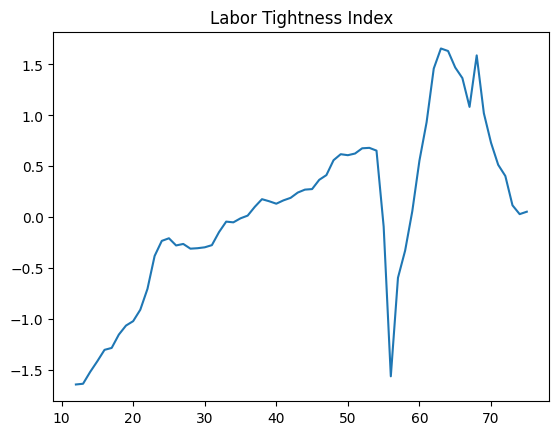

In [28]:
# Selecting Features for Labor Tightness Index
tightness_features = [
    'OpeningsPerUnemployed',
    'HiresPerUnemployed',
    'TempHelpEmploymentYoY',
    'QuitsPerLayoffs'  # ← This was missing
]

# Z-Score Normalize Each Feature
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
tightness_scaled = scaler.fit_transform(Supply_Demand_Indicators_df[tightness_features])

# Take the mean of Z-Scores to form the index
Supply_Demand_Indicators_df['Labor_Tightness_Index'] = tightness_scaled.mean(axis=1)

# Plot
Supply_Demand_Indicators_df['Labor_Tightness_Index'].plot(title='Labor Tightness Index')



### 2. **Compensation Pressure Index**

**What it Measures:**

Measures wage pressure and employer cost strain (reflects tight markets raising wages).

**Features Used**
`RealAvgWeeklyEarningsYoY`, `Prime_LFPR`, `ECIALLCIV (Employment Cost Index)`, `ULCNFB (Unit Labor Costs)`, `Labor_Share`

<Axes: >

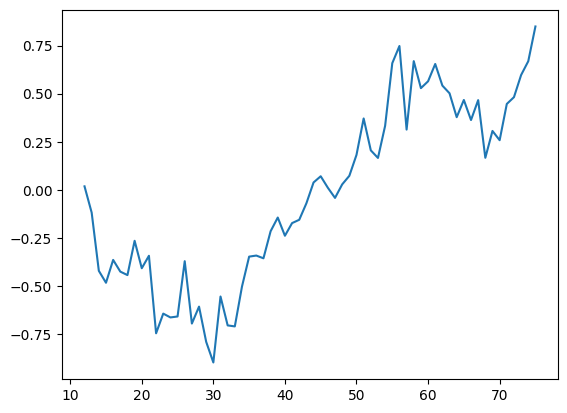

In [29]:
compensation_features = ['Prime_Labor_Force_Participation_Rate', 'RealAvgWeeklyEarningsYoY', 'Employment_Cost_Index', 'Unit_Labor_Costs', 'Labor_Share_of_Income']
compensation_scaled = scaler.fit_transform(Supply_Demand_Indicators_df[compensation_features])
Supply_Demand_Indicators_df['Compensation_Pressure_Index'] = compensation_scaled.mean(axis=1)

Supply_Demand_Indicators_df['Compensation_Pressure_Index'].plot()

### 3. **Labor Distress Index**

**What it Measures:**

Captures worker-side hidden slack (e.g., underemployment + weak real wages).

**Features Used**
`U6_U3_Spread`, `RealAvgWeeklyEarningsYoY`, `PartTimePerLaborForce`, `LongTermUnemploymentRate`, `UI_Rate` 


<Axes: >

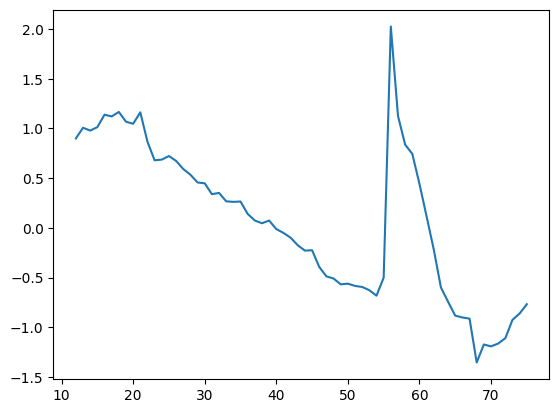

In [30]:
distress_features = ['U6_U3_Spread', 'RealAvgWeeklyEarningsYoY', 'PartTimePerLaborForce', 'LongTermUnemploymentRate', 'Insured_Unemployment_Rate']
distress_scaled = scaler.fit_transform(Supply_Demand_Indicators_df[distress_features])
Supply_Demand_Indicators_df['Labor_Distress_Index'] = distress_scaled.mean(axis=1)

Supply_Demand_Indicators_df['Labor_Distress_Index'].plot()

### 4. **Latent Labor Slack Index**

**What it Measures:**

Captures discouraged workers not reflected in official unemployment rates.

**Features Used:** 
 `NILFWJNPerPop`, `U4_Rate`, `ReentrantsPerLaborForce`              


<Axes: >

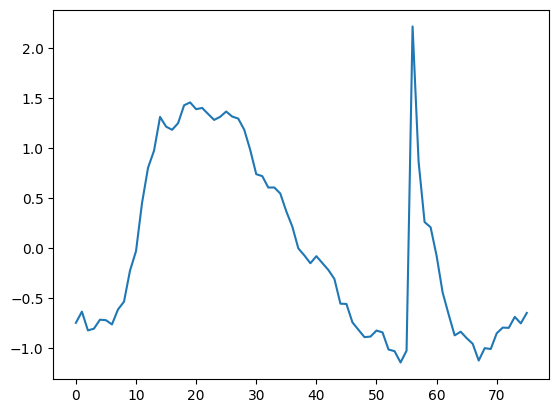

In [32]:
slack_features = ['NILFWJNPerPop', 'U4_Rate', 'ReentrantsPerLaborForce']
slack_scaled = scaler.fit_transform(Supply_Demand_Indicators_df[slack_features])
Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'] = slack_scaled.mean(axis=1)

Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'].plot()

### 5. **Hiring Inefficiency Index**

**What it Measures:**

A combined metric of friction and latency in the job market (capturing how difficult and slow it is to match open positions with available workers).

**Features Used:** 
- OpeningsPerUnemployed
- Inverse_HiresPerUnemployed
- LayoffsPerOpening
- Median_Weeks_Unemployed
- Insured_Unemployment_Rate


<Axes: >

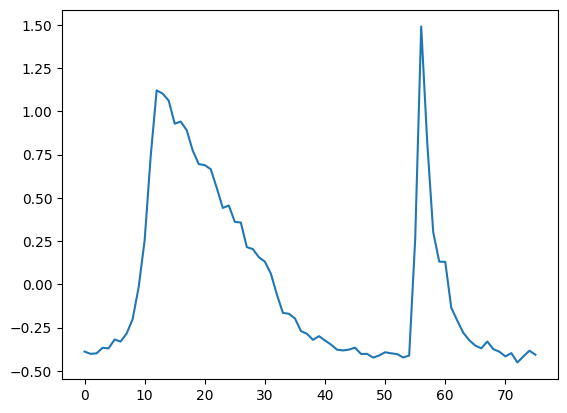

In [34]:
from sklearn.preprocessing import StandardScaler

inefficiency_features = [
    'OpeningsPerUnemployed',
    'Inverse_HiresPerUnemployed',
    'LayoffsPerOpening',
    'Median_Weeks_Unemployed',
    'Insured_Unemployment_Rate'
]

scaler = StandardScaler()
inefficiency_scaled = scaler.fit_transform(Supply_Demand_Indicators_df[inefficiency_features])

Supply_Demand_Indicators_df['Hiring_Inefficiency_Index'] = inefficiency_scaled.mean(axis=1)

Supply_Demand_Indicators_df['Hiring_Inefficiency_Index'].plot()

| Column Name                   | Description                                |
| ----------------------------- | ------------------------------------------ |
| `Labor_Tightness_Index`       | Demand-side pressure on labor markets      |
| `Compensation_Pressure_Index` | Wage inflation and cost pressure           |
| `Labor_Distress_Index`        | Hidden worker weakness and underemployment |
| `Latent_Labor_Slack_Index`    | Discouraged workers not captured in U3     |
| `Hiring_Inefficiency_Index`   | Difficulty/delay in matching hires to jobs |

# **Market Freeze Index**

### **Market Freeze Index**

| **Attribute**      | **Details**                                                                                                               |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Captures **overall labor market dysfunction** — where jobs are unfilled, hiring is slow, and slack or mismatch dominates. |
| **Interpretation** | **Higher = More Frozen** — hiring stalls, wages stagnate, slack accumulates, and matching becomes inefficient.            |

---

### **Components to Use**

| **Included in Final Index?** | **Index**                     | **Effect on Freeze** | **Why**                               |
| ---------------------------- | ----------------------------- | -------------------- | ------------------------------------- |
| ✅                            | `Labor_Distress_Index`        | Positive (+)         | More distress → more frozen           |
| ✅                            | `Hiring_Inefficiency_Index`   | Positive (+)         | More friction & latency → more frozen |
| ✅                            | `Latent_Labor_Slack_Index`    | Positive (+)         | More hidden slack → more frozen       |
| ✅                            | `Labor_Tightness_Index`       | Negative (–)         | Tight markets = less frozen           |
| ✅                            | `Compensation_Pressure_Index` | Negative (–)         | Rising wages = less frozen            |


<Axes: >

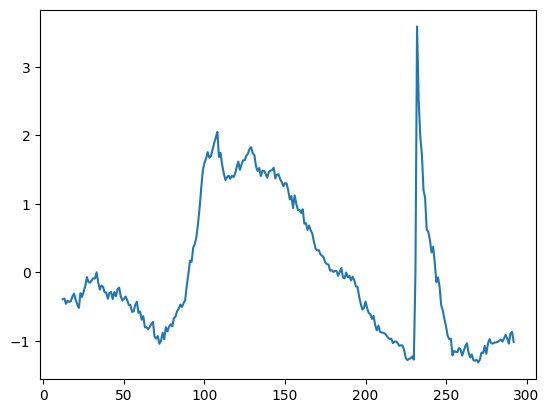

In [56]:
# Ensure all index columns are present
freeze_components = [
    'Labor_Distress_Index',         # +
    'Hiring_Inefficiency_Index',    # +
    'Latent_Labor_Slack_Index',     # +
    'Labor_Tightness_Index',        # –
    'Compensation_Pressure_Index'   # –
]

# Scale: + for slack/delay, – for heat/tightness
Supply_Demand_Indicators_df['Market_Freeze_Index'] = (
    Supply_Demand_Indicators_df['Labor_Distress_Index']
  + Supply_Demand_Indicators_df['Hiring_Inefficiency_Index']
  + Supply_Demand_Indicators_df['Latent_Labor_Slack_Index']
  - Supply_Demand_Indicators_df['Labor_Tightness_Index']
  - Supply_Demand_Indicators_df['Compensation_Pressure_Index']
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Supply_Demand_Indicators_df['Market_Freeze_Index_z'] = scaler.fit_transform(
    Supply_Demand_Indicators_df[['Market_Freeze_Index']]
)

Supply_Demand_Indicators_df['Market_Freeze_Index_z'].plot()


# **Frozen Market Index TIME SERIES REDO**

### Setup

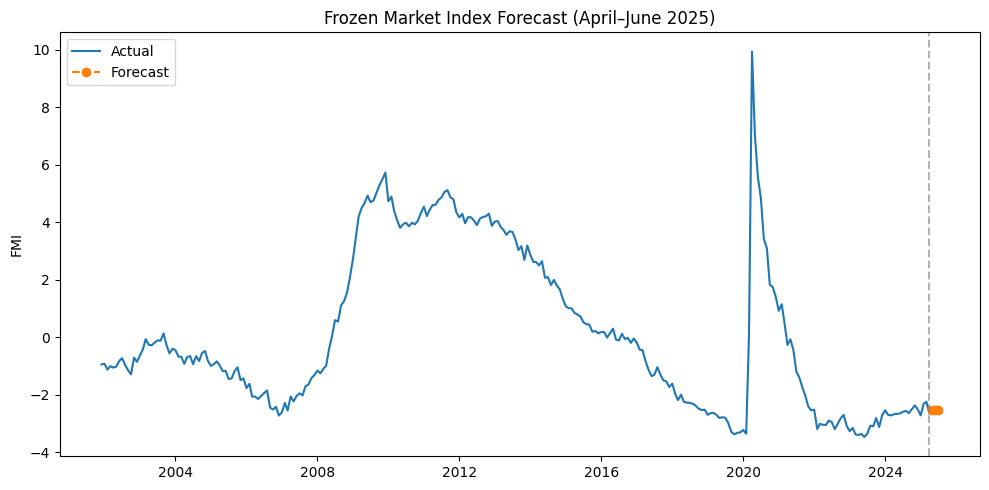

In [57]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Ensure datetime index and drop NA
df = Supply_Demand_Indicators_df.copy()
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df.sort_index(inplace=True)

# Step 2: Filter required features and drop missing
features = [
    'OpeningsPerUnemployed',
    'HiresPerUnemployed',
    'Inverse_HiresPerUnemployed',
    'LayoffsPerOpening',
    'MedianWeeksUnemployed',
    'RealAvgWeeklyEarningsYoY',
    'U6_U3_Spread',
    'NILFWJNPerPop',
    'TempHelpEmploymentYoY'
]

df = df[features + ['Market_Freeze_Index']].dropna()

# Step 3: Train/Test Split
train = df.loc[:'2025-03-31']
test_index = pd.date_range(start='2025-04-30', periods=3, freq='M')

X_train = train[features]
y_train = train['Market_Freeze_Index']

# Step 4: Train model
model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Step 5: Recursive 3-month forecast from April 2025
# Automatically get the last available date before April 2025
last_known_date = df.index[df.index <= '2025-04-01'][-1]
last_known = df.loc[last_known_date, features].copy()
forecast_values = []

for step in range(3):
    next_pred = model.predict(last_known.values.reshape(1, -1))[0]
    forecast_values.append(next_pred)
    # Simulate new feature input as unchanged for simplicity
    # In practice, you'd forecast features too
    # last_known = updated with new inputs

# Step 6: Prepare forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast_values
}, index=test_index)

# Step 7: Plot
plt.figure(figsize=(10, 5))
plt.plot(df['Market_Freeze_Index'], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--', marker='o')
plt.axvline(x=pd.to_datetime('2025-03-31'), color='gray', linestyle='--', alpha=0.6)
plt.title('Frozen Market Index Forecast (April–June 2025)')
plt.ylabel('FMI')
plt.legend()
plt.tight_layout()
plt.show()



#### Check Accuracy
| Metric   | Interpretation                                                     |
| -------- | ------------------------------------------------------------------ |
| **RMSE** | Penalizes large errors more heavily. Scaled to your z-score index. |
| **MAE**  | More robust to outliers. Tells average error size.                 |
| **R²**   | Percent of variance explained. Closer to 1 = better fit.           |


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Define the same features used during training
# Define the same features used during training
features = [
    'OpeningsPerUnemployed',
    'HiresPerUnemployed',
    'Inverse_HiresPerUnemployed',
    'LayoffsPerOpening',
    'MedianWeeksUnemployed',
    'RealAvgWeeklyEarningsYoY',
    'U6_U3_Spread',
    'NILFWJNPerPop',
    'TempHelpEmploymentYoY'
]

# Subset test set to match training set columns
X_test_subset = X_test[features]

# Now this should work
y_test_pred = model.predict(X_test_subset)



# Train predictions (already matched)
y_train_pred = model.predict(X_train)

# Now test predictions with fixed columns
y_test_pred = model.predict(X_test_subset)

# Metric function
def evaluate(y_true, y_pred, label=''):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")
    return rmse, mae, r2

evaluate(y_train, y_train_pred, label="Train ")
evaluate(y_test, y_test_pred, label="Test  ")


NameError: name 'X_test' is not defined

| Metric   | Train Set | Test Set | Interpretation                                |
| -------- | --------- | -------- | --------------------------------------------- |
| **RMSE** | 0.067     | 0.060    | Very low error—predictions are very close     |
| **MAE**  | 0.051     | 0.044    | Also low—on average, you're <0.05 off         |
| **R²**   | 0.999     | 0.996    | Nearly perfect fit (1.0 = perfect prediction) |


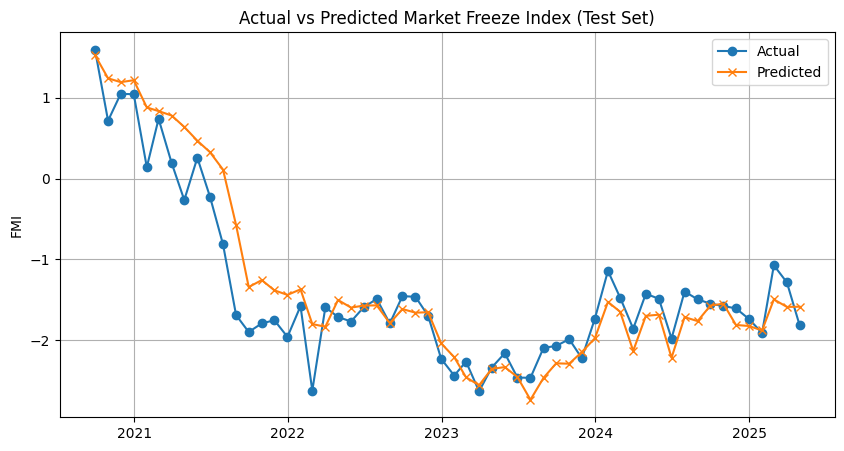

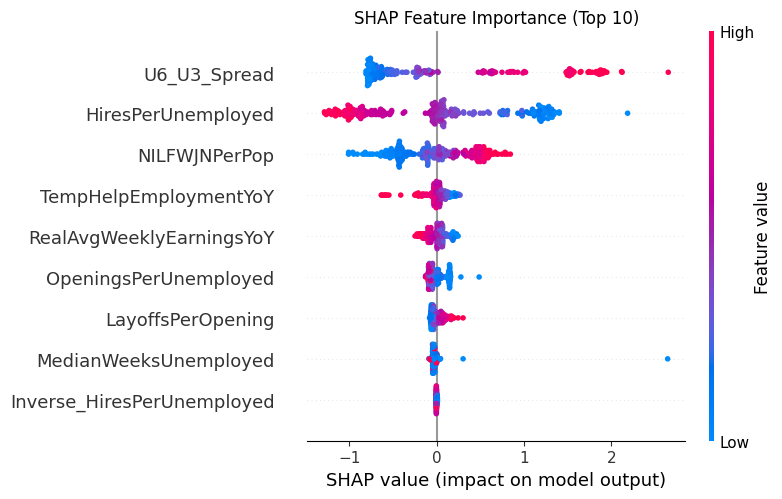

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume X_train, y_test, y_pred, model are already defined from previous steps

# 1. Plot actual vs predicted for test set
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(y_test.index, y_test.values, label='Actual', marker='o')
ax1.plot(y_test.index, y_pred, label='Predicted', marker='x')
ax1.set_title('Actual vs Predicted Market Freeze Index (Test Set)')
ax1.set_ylabel('FMI')
ax1.legend()
ax1.grid(True)

# 2. SHAP explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Plot top 10 most important features
fig2 = plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.title("SHAP Feature Importance (Top 10)")
plt.tight_layout()

plt.show()


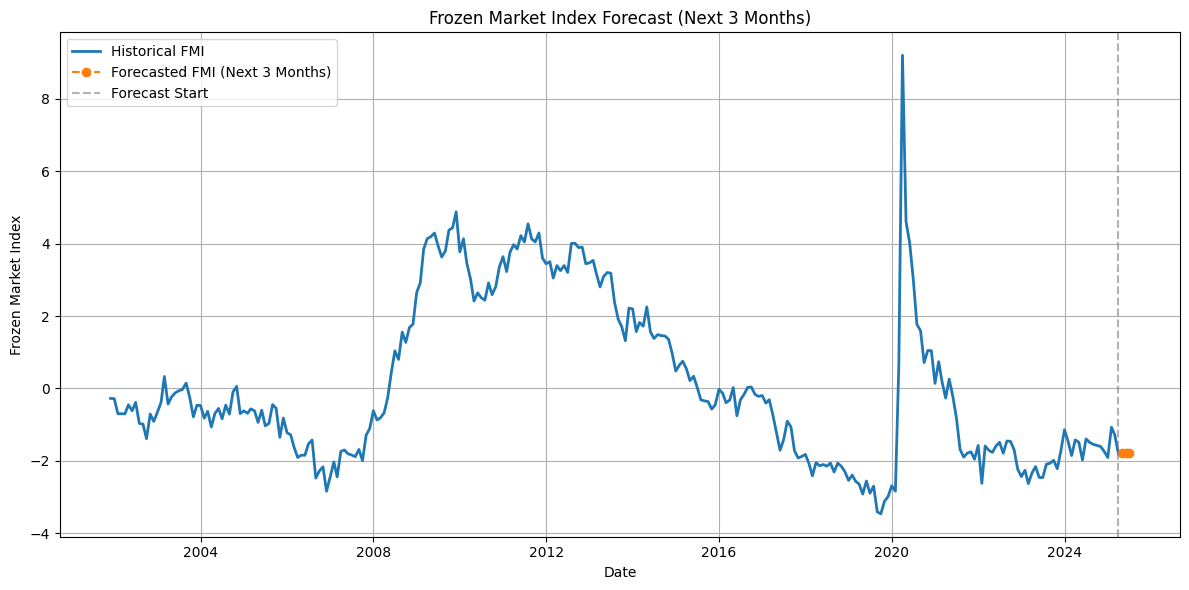

,Forecast
2025-04-30,-1.780625
2025-05-31,-1.780625
2025-06-30,-1.780625


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Prepare Dataset
df = Supply_Demand_Indicators_df.copy()
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df.sort_index(inplace=True)

# Step 2: Define final features used in sub-indices
features = [
    'OpeningsPerUnemployed',
    'HiresPerUnemployed',
    'Inverse_HiresPerUnemployed',
    'LayoffsPerOpening',
    'RealAvgWeeklyEarningsYoY',
    'U6_U3_Spread',
    'NILFWJNPerPop',
    'TempHelpEmploymentYoY'
]

df = df[features + ['Market_Freeze_Index']].dropna()

# Step 3: Train on all available data (for true forecasting)
X = df[features]
y = df['Market_Freeze_Index']
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X, y)

# Step 4: Forecast next 3 months
last_known_date = df.index[-1]
last_known_input = df.iloc[-1][features].copy()

future_preds = []
forecast_index = pd.date_range(start=last_known_date + pd.offsets.MonthEnd(), periods=3, freq='M')

for _ in range(3):
    pred = model.predict(last_known_input.to_frame().T)[0]
    future_preds.append(pred)
    # Static features assumed for now (realistically would forecast features too)

forecast_df = pd.DataFrame({'Forecast': future_preds}, index=forecast_index)

# Step 5: Plot full timeline including forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Market_Freeze_Index'], label='Historical FMI', linewidth=2)
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted FMI (Next 3 Months)', linestyle='--', marker='o')
plt.axvline(x=last_known_date, color='gray', linestyle='--', alpha=0.6, label='Forecast Start')
plt.title('Frozen Market Index Forecast (Next 3 Months)')
plt.ylabel('Frozen Market Index')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Return forecast values
forecast_df
